# Bulk RNA-seq R実装 (iDEP or DESeq2使う)

### 安水さん論文 (Nat.Comm. 2022)：[論文](https://www.nature.com/articles/s41467-022-31951-8), [プレスリリース](https://resou.osaka-u.ac.jp/ja/research/2022/20220805_1), [Githubコード](https://github.com/yyoshiaki/MG_thymoma_Manuscript_2021/blob/master/200703_TCGA_RNAseq.R#L45)

In [1]:
# 実行環境
R.version

               _                           
platform       x86_64-apple-darwin17.0     
arch           x86_64                      
os             darwin17.0                  
system         x86_64, darwin17.0          
status                                     
major          4                           
minor          2.0                         
year           2022                        
month          04                          
day            22                          
svn rev        82229                       
language       R                           
version.string R version 4.2.0 (2022-04-22)
nickname       Vigorous Calisthenics       

## 0. パッケージのロード

In [3]:
# パッケージを使用
library(TCGAbiolinks) # ver 2.26.0
library(biomaRt) # 2.54.1
library(DESeq2)  # 1.38.3
library(ggplot2) # 3.4.2
library(plyr)
library(dplyr)
library(viridis)
library(EnhancedVolcano)
library(pheatmap)
library(vsn)
library(scales)

In [ ]:
# インストール用
BiocManager::install("org.Hs.eg.db")

In [ ]:
# ver確認
packageVersion("ggplot2")

In [ ]:
# helpでパッケージに含まれる関数一覧見れる
help(package = DESeq2)

## 1. 発現量データ

In [4]:
# 発現量データをダウンロード
proj <- "TCGA-THYM"
query <- GDCquery(
  project = proj,
  data.category = "Transcriptome Profiling", 
  data.type = "Gene Expression Quantification",
  workflow.type = "STAR - Counts" # 論文の"HTSeq - Counts"はエラー出る
)
GDCdownload(query) # 500MBぐらいをダウンロード
data <- GDCprepare(query) # 処理に1分ぐらいかかる

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-THYM

--------------------

oo Filtering results

--------------------

ooo By data.type

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------


Of the 122 files for download 122 already exist.

All samples have been already downloaded



|====================================================|100%                      Completed after 15 s 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

Available assays in SummarizedExperiment : 
  => unstranded
  => stranded_first
  => stranded_second
  => tpm_unstrand
  => fpkm_unstrand
  => fpkm_uq_unstrand



In [5]:
# データ構造確認
data # 全体構造を表示
assay(data)[1:5,] 　　　# 遺伝子名/サンプル名 で 発現量テーブル表示
colData(data)[1:5,1:3] # サンプル名/サンプルの情報
rowData(data)[1:5,1:5] # 遺伝子名/遺伝子の情報

class: RangedSummarizedExperiment 
dim: 60660 122 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(10): source type ... hgnc_id havana_gene
colnames(122): TCGA-XM-A8RB-01A-11R-A42C-07
  TCGA-X7-A8M0-01A-11R-A42C-07 ... TCGA-ZB-A961-01A-11R-A42S-07
  TCGA-X7-A8M1-01A-11R-A42C-07
colData names(56): barcode patient ... year_of_death sample.aux

,TCGA-XM-A8RB-01A-11R-A42C-07,TCGA-X7-A8M0-01A-11R-A42C-07,TCGA-ZB-A96M-01A-11R-A42S-07,TCGA-4V-A9QT-01A-11R-A42C-07,TCGA-XU-AAY1-01A-11R-A42C-07,TCGA-X7-A8DB-01A-11R-A42C-07,TCGA-XM-AAZ3-01A-11R-A42C-07,TCGA-XU-AAXX-01A-11R-A42C-07,TCGA-XU-A936-01A-11R-A42C-07,TCGA-XU-A930-01A-11R-A42C-07,⋯,TCGA-X7-A8DG-01A-11R-A42C-07,TCGA-4X-A9FC-01A-11R-A42C-07,TCGA-XM-A8RC-01A-11R-A42C-07,TCGA-X7-A8D7-01A-11R-A42C-07,TCGA-ZB-A96O-01A-11R-A42S-07,TCGA-ZB-A96L-01A-11R-A42S-07,TCGA-5U-AB0D-01A-11R-A42C-07,TCGA-XM-A8RL-01A-11R-A42C-07,TCGA-ZB-A961-01A-11R-A42S-07,TCGA-X7-A8M1-01A-11R-A42C-07
ENSG00000000003.15,311,3109,3228,865,862,250,3761,978,3066,2238,⋯,750,1376,4653,451,538,4858,202,392,906,2728
ENSG00000000005.6,2,15,13,9,3,15,70,2,34,31,⋯,3,7,57,11,17,13,9,17,40,42
ENSG00000000419.13,1778,3379,2224,2961,1611,1558,2023,2137,2013,3292,⋯,1626,2172,3504,1868,1467,3023,400,2271,1585,2047
ENSG00000000457.14,875,1512,1231,860,406,663,720,856,1154,2284,⋯,553,647,1358,1287,348,1330,106,953,994,1021
ENSG00000000460.17,1324,343,739,1104,394,788,198,845,381,1054,⋯,481,711,1453,1106,462,471,25,1313,558,535


DataFrame with 5 rows and 3 columns
                                            barcode      patient
                                        <character>  <character>
TCGA-XM-A8RB-01A-11R-A42C-07 TCGA-XM-A8RB-01A-11R.. TCGA-XM-A8RB
TCGA-X7-A8M0-01A-11R-A42C-07 TCGA-X7-A8M0-01A-11R.. TCGA-X7-A8M0
TCGA-ZB-A96M-01A-11R-A42S-07 TCGA-ZB-A96M-01A-11R.. TCGA-ZB-A96M
TCGA-4V-A9QT-01A-11R-A42C-07 TCGA-4V-A9QT-01A-11R.. TCGA-4V-A9QT
TCGA-XU-AAY1-01A-11R-A42C-07 TCGA-XU-AAY1-01A-11R.. TCGA-XU-AAY1
                                       sample
                                  <character>
TCGA-XM-A8RB-01A-11R-A42C-07 TCGA-XM-A8RB-01A
TCGA-X7-A8M0-01A-11R-A42C-07 TCGA-X7-A8M0-01A
TCGA-ZB-A96M-01A-11R-A42S-07 TCGA-ZB-A96M-01A
TCGA-4V-A9QT-01A-11R-A42C-07 TCGA-4V-A9QT-01A
TCGA-XU-AAY1-01A-11R-A42C-07 TCGA-XU-AAY1-01A

DataFrame with 5 rows and 5 columns
                     source     type     score     phase            gene_id
                   <factor> <factor> <numeric> <integer>        <character>
ENSG00000000003.15   HAVANA     gene        NA        NA ENSG00000000003.15
ENSG00000000005.6    HAVANA     gene        NA        NA  ENSG00000000005.6
ENSG00000000419.13   HAVANA     gene        NA        NA ENSG00000000419.13
ENSG00000000457.14   HAVANA     gene        NA        NA ENSG00000000457.14
ENSG00000000460.17   HAVANA     gene        NA        NA ENSG00000000460.17

In [7]:
#------ 列について (column：サンプル名の方) ------#

# 重複列があるか確認
# substr(colnames(data), 1, 12) # substr()関数：◯文字目までのみ表示するコマンド
# duplicated(substr(colnames(data), 1, 12)) # duplicated()関数：重複してるかをTrue/Falseのリストで返す
colnames(data[,duplicated(substr(colnames(data), 1, 12))]) # 重複してる遺伝子名を確認

# dataから重複列を削除
data <- data[,!duplicated(substr(colnames(data), 1, 12))] # 重複無し行のみを取り出し、条件指定は「!FALSE」で

# 列の名前を12文字の省略形に書き換え
colnames(data) <- substr(colnames(data), 1, 12)



#------ 行について (row：遺伝子名の方) ------#
row.names(data) = rowRanges(data)$gene_name # ENSG0000〜みたいなのから普通の遺伝子名にする

# 結構重複あるけどどうするんやろこれ？ → 臨床データと統合した後に処理してた
#row.names(data[!duplicated(row.names(data)),])



# 出力
#write.csv(assay(data), 'rawcounts.csv')

# データ確認
head(assay(data)) # 60660遺伝子 × 120サンプル数

character(0)

,TCGA-XM-A8RB,TCGA-X7-A8M0,TCGA-ZB-A96M,TCGA-4V-A9QT,TCGA-XU-AAY1,TCGA-X7-A8DB,TCGA-XM-AAZ3,TCGA-XU-AAXX,TCGA-XU-A936,TCGA-XU-A930,⋯,TCGA-XM-A8RE,TCGA-X7-A8DG,TCGA-4X-A9FC,TCGA-XM-A8RC,TCGA-ZB-A96O,TCGA-ZB-A96L,TCGA-5U-AB0D,TCGA-XM-A8RL,TCGA-ZB-A961,TCGA-X7-A8M1
TSPAN6,311,3109,3228,865,862,250,3761,978,3066,2238,⋯,920,750,1376,4653,538,4858,202,392,906,2728
TNMD,2,15,13,9,3,15,70,2,34,31,⋯,19,3,7,57,17,13,9,17,40,42
DPM1,1778,3379,2224,2961,1611,1558,2023,2137,2013,3292,⋯,2518,1626,2172,3504,1467,3023,400,2271,1585,2047
SCYL3,875,1512,1231,860,406,663,720,856,1154,2284,⋯,882,553,647,1358,348,1330,106,953,994,1021
C1orf112,1324,343,739,1104,394,788,198,845,381,1054,⋯,1084,481,711,1453,462,471,25,1313,558,535
FGR,1539,3599,963,557,769,381,288,457,1970,879,⋯,1206,743,508,1418,328,341,218,677,795,572


## 2. 臨床データ

In [8]:
# ダウンロード
clinical <- GDCquery_clinic(project = "TCGA-THYM", type = "clinical")
query_cli <- GDCquery(project = "TCGA-THYM", 
                  data.category = "Clinical", 
                  file.type = "xml")
GDCdownload(query_cli)
clinical <- GDCprepare_clinic(query_cli, clinical.info = "patient")

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-THYM

--------------------

oo Filtering results

--------------------

ooo By file.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases


ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------


Of the 135 files for download 135 already exist.

All samples have been already downloaded



  |======================================================================| 100%


To get the following information please change the clinical.info argument

=> new_tumor_events: new_tumor_event 
=> drugs: drug 
=> follow_ups: follow_up 
=> radiations: radiation

Parsing follow up version: follow_up_v4.0



  |======================================================================| 100%


Adding stage event information



  |======================================================================| 100%


Adding primary pathology information



  |======================================================================| 100%


Updating days_to_last_followup and vital_status from follow_up information using last entry

Parsing follow up version: follow_up_v4.0



  |======================================================================| 100%


Warning message:
“There were 5 warnings in `dplyr::summarise()`.
The first warning was:
ℹ In argument: `days_to_last_followup = max(as.numeric(days_to_last_followup),
  na.rm = TRUE)`.
ℹ In group 3: `bcr_patient_barcode = "TCGA-3G-AB14"`.
Caused by warning in `max()`:
!  max の引数に有限な値がありません: -Inf を返します 
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings.”
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
ℹ The deprecated feature was likely used in the TCGAbiolinks package.
  Please report the issue at
  <https://github.com/BioinformaticsFMRP/TCGAbiolinks/issues>.”


In [9]:
# データ確認
#clinical # 135行 × 53列

# 重複削除
clinical <- clinical[!duplicated(clinical$bcr_patient_barcode),] # 124行に減る

# 行の名前変更
rownames(clinical) <- clinical$bcr_patient_barcode

# dataと対応するサンプルだけ残す
clinical <- clinical[colnames(data),] # 120行に減る
head(clinical)

# 出力
#write.csv(clinical, 'clinical.csv')

,bcr_patient_barcode,additional_studies,tissue_source_site,patient_id,bcr_patient_uuid,informed_consent_verified,icd_o_3_site,icd_o_3_histology,icd_10,tissue_prospective_collection_indicator,⋯,stage_event_masaoka_stage,primary_pathology_tumor_tissue_site,primary_pathology_histological_type_list,primary_pathology_initial_pathologic_diagnosis_method,primary_pathology_init_pathology_dx_method_other,primary_pathology_days_to_initial_pathologic_diagnosis,primary_pathology_age_at_initial_pathologic_diagnosis,primary_pathology_year_of_initial_pathologic_diagnosis,primary_pathology_history_myasthenia_gravis,primary_pathology_section_myasthenia_gravis
,<chr>,<lgl>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
TCGA-XM-A8RB,TCGA-XM-A8RB,NA,XM,A8RB,335535A1-E3D4-41A1-BBDB-1D5AFD5ACFD3,YES,C37.9,8583/1,C37,NO,⋯,I,Thymus,Thymoma; Type B1,Median Sternectomy,,0,68,2011,NO,
TCGA-X7-A8M0,TCGA-X7-A8M0,NA,X7,A8M0,262B4693-961B-4006-BE4E-E6F38A1CCE4A,YES,C37.9,8585/3,C37,NO,⋯,IIa,Thymus,Thymoma; Type B2Thymoma; Type B3,Core needle biopsy,,0,61,2007,NO,
TCGA-ZB-A96M,TCGA-ZB-A96M,NA,ZB,A96M,3EAB80E6-21BC-45DD-A7B5-411A5DAD4E9A,YES,C38.1,8582/3,C38.1,NO,⋯,I,Thymus,Thymoma; Type AB,Median Sternectomy,,0,56,2011,YES,Class II
TCGA-4V-A9QT,TCGA-4V-A9QT,NA,4V,A9QT,3F691BF4-9558-4454-889E-CFA7D0DE96CC,YES,C37.9,8583/3,C37,NO,⋯,IIa,Thymus,Thymoma; Type B1,Median Sternectomy,,0,79,2012,YES,
TCGA-XU-AAY1,TCGA-XU-AAY1,NA,XU,AAY1,09F8ACFC-4D80-4005-9F40-7485309997F5,YES,C37.9,8582/3,C37,NO,⋯,IIa,Thymus,Thymoma; Type AB,Median Sternectomy,,0,51,2005,NO,
TCGA-X7-A8DB,TCGA-X7-A8DB,NA,X7,A8DB,4165391B-6122-4E87-BA91-CE935E0B3CF4,YES,C38.1,8584/1,C38.1,NO,⋯,I,Thymus,Thymoma; Type B2,Core needle biopsy,,0,71,2009,NO,


## 3. データを統合

In [10]:
# 発現量データ：colData(data) = 120サンプル × 56列
# 臨床データ　：clinical = 120サンプル × 53列

# 統合する cbind()関数
colData(data) <- cbind(colData(data), clinical[row.names(colData(data)),]) # 120サンプル × 109列

In [11]:
# 欠損あるサンプルを削除する 

# (論文やとis.na()関数使ってるけど、NA表記でないので上手く抽出できない...)
# clinical$primary_pathology_history_myasthenia_gravis # 確認すると、3つ欠損してるが...

# 無理やり条件式使うか
temp_list = clinical$primary_pathology_history_myasthenia_gravis=="YES" | clinical$primary_pathology_history_myasthenia_gravis=="NO"
# clinical[!temp_list,]

# dataを書き換え
data <- data[,temp_list] # 3つ消える 120->117列

# 遺伝子名重複してるやつ消す
data <- data[!duplicated(row.names(data)),] # 60660 -> 59427行

# Yes/Noラベルでソートできるようにする：factor()関数
data$primary_pathology_history_myasthenia_gravis <- 
  factor(data$primary_pathology_history_myasthenia_gravis, levels = c("NO", "YES"))

## → [iDEP](http://bioinformatics.sdstate.edu/idep96/)に使う用のデータ出力

In [12]:
# iDEPに使える形にデータ整形
# サンプル名を 「WT_1,WT_2,...,CN_1,CN_2,...」みたいな「条件_(数字)」にしないと 発現変動解析のところでバグる(計算処理が終わらない)

iDEP_data <- data

#--- 名前を書き換える ---#
temp_list = iDEP_data$primary_pathology_history_myasthenia_gravis=="YES"
a = temp_list
index_yes = 1
index_no = 1
for (i in 1:length(temp_list)){
    if (temp_list[i]) {
        a[i] = paste(temp_list[i], index_yes, sep="_")
        index_yes = index_yes + 1
    }
    else {
        a[i] = paste(temp_list[i], index_no, sep="_")
        index_no = index_no + 1
    }
}
colnames(iDEP_data) <- a
#---------------------#


# 発現量データ出力
write.csv(assay(iDEP_data), 'output/iDEP_rawcounts.csv', quote = F) # 引用符(quote)ありだとiDEPの読み込みで臨床データと統合するとこバグる

# 臨床データ出力
row_list = c("primary_pathology_history_myasthenia_gravis","primary_pathology_histological_type_list","gender")
write.csv(colData(iDEP_data)[,row_list], 'output/iDEP_clinical.csv')
temp <- read.csv('output/iDEP_clinical.csv') # 直で転置t()して出力するとなんかバグるので回避
write.table(t(temp), 'output/iDEP_clinical.csv', sep = ",", col.names=F, quote = F)


#--- iDEPで読み込み ---#
# 'rawcounts.csv'を Upload expression data に
# 'clinical.csv' を Upload an experiment design file に
#---------------------#

## 4. DESeq2

In [19]:
# DESeq2にブチ込む用のデータにする
ddsSE <- DESeqDataSet(data, design = ~ primary_pathology_history_myasthenia_gravis)
head(counts(ddsSE)) # 表示

# 発現量少ないやつ除去
keep = rowMeans(counts(ddsSE)) >= 5
ddsSE <- ddsSE[keep,]

renaming the first element in assays to 'counts'



,TCGA-XM-A8RB,TCGA-X7-A8M0,TCGA-ZB-A96M,TCGA-4V-A9QT,TCGA-XU-AAY1,TCGA-X7-A8DB,TCGA-XM-AAZ3,TCGA-XU-AAXX,TCGA-XU-A936,TCGA-XU-A930,⋯,TCGA-XM-A8RE,TCGA-X7-A8DG,TCGA-4X-A9FC,TCGA-XM-A8RC,TCGA-ZB-A96O,TCGA-ZB-A96L,TCGA-5U-AB0D,TCGA-XM-A8RL,TCGA-ZB-A961,TCGA-X7-A8M1
TSPAN6,311,3109,3228,865,862,250,3761,978,3066,2238,⋯,920,750,1376,4653,538,4858,202,392,906,2728
TNMD,2,15,13,9,3,15,70,2,34,31,⋯,19,3,7,57,17,13,9,17,40,42
DPM1,1778,3379,2224,2961,1611,1558,2023,2137,2013,3292,⋯,2518,1626,2172,3504,1467,3023,400,2271,1585,2047
SCYL3,875,1512,1231,860,406,663,720,856,1154,2284,⋯,882,553,647,1358,348,1330,106,953,994,1021
C1orf112,1324,343,739,1104,394,788,198,845,381,1054,⋯,1084,481,711,1453,462,471,25,1313,558,535
FGR,1539,3599,963,557,769,381,288,457,1970,879,⋯,1206,743,508,1418,328,341,218,677,795,572


In [14]:
#--- 変動解析実行 ---#
ddsSE <- DESeq(ddsSE) # ちょっと時間かかる
#------------------#

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 2210 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [15]:
# 変数res：見慣れた形の表にまとめる、log2(FC)とか
res <- results(ddsSE, name = "primary_pathology_history_myasthenia_gravis_YES_vs_NO", alpha = 0.1, lfcThreshold = 1)
res # データ表示
summary(res) # サマリー表示

log2 fold change (MLE): primary pathology history myasthenia gravis YES vs NO 
Wald test p-value: primary pathology history myasthenia gravis YES vs NO 
DataFrame with 25524 rows and 6 columns
            baseMean log2FoldChange     lfcSE      stat    pvalue      padj
           <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
TSPAN6     1658.4232     -0.4381373 0.1770329         0         1         1
TNMD         16.5374     -0.2946700 0.3078819         0         1         1
DPM1       1776.3187     -0.0916664 0.0923769         0         1         1
SCYL3       749.7653      0.2084610 0.1064231         0         1         1
C1orf112    516.7689      0.1135791 0.1885524         0         1         1
...              ...            ...       ...       ...       ...       ...
AL049777.1   31.8349     -0.1219125  0.343898         0         1         1
AC010980.1  132.1607      0.8985615  0.238799         0         1         1
AC073611.1   23.7298     -0.0299539  0.151301  


out of 25524 with nonzero total read count
adjusted p-value < 0.1
LFC > 1.00 (up)    : 123, 0.48%
LFC < -1.00 (down) : 124, 0.49%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [16]:
## 発現量とP値がいい感じのやつ抽出しとく ##

# P値低い順にソート
resOrdered <- res[order(res$padj),]
dea <- as.data.frame(resOrdered)

# 生データ出力
write.csv(dea, file = "output/DESeq2_res.csv")
head(dea) # 確認

# up/downの遺伝子を抜き出して出力
degs <- subset(resOrdered, padj < 0.1) # subset関数(データ,行の条件)：p値が0.1未満
degs <- degs[abs(degs$log2FoldChange) > 1,] # 発現量
genes.up <- row.names(degs[degs$log2FoldChange >= 0,])
genes.down <- row.names(degs[degs$log2FoldChange < 0,])
write(genes.up, file = "output/DESeq2_upgenes.txt")
write(genes.down, file = "output/DESeq2_downgenes.txt")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLDC,150.36597,3.787264,0.3563367,7.821996,5.199245e-15,1.327055e-10
HOXC8,148.99446,-5.248492,0.6404504,-6.633600,3.275971e-11,2.090397e-07
NGB,320.96367,4.551338,0.5334973,6.656712,2.800206e-11,2.090397e-07
SOX2,295.67128,-4.524270,0.5276299,-6.679436,2.398633e-11,2.090397e-07
LINC02641,44.53440,3.183113,0.3352436,6.512018,7.414759e-11,3.785086e-07
CTSLP8,34.06159,-5.864736,0.7594438,-6.405657,1.497234e-10,6.369235e-07


In [17]:
# 変数df：MGの臨床データだけ抽出
df <- as.data.frame(colData(ddsSE)[,c("primary_pathology_history_myasthenia_gravis", "primary_pathology_histological_type_list")])
head(df)

levels(df$primary_pathology_histological_type_list) <- 
    c( "Thymoma; Type A", "Thymoma; Type AThymoma; Type AB", "Thymoma; Type AB", "Thymoma; Type B1"
      , "Thymoma; Type B1Thymoma; Type B2", "Thymoma; Type B2", "Thymoma; Type B2Thymoma; Type B3"
      , "Thymoma; Type B3", "Thymoma; Type C" )

# plyr::revalue関数
df$primary_pathology_histological_type_list <- revalue(df$primary_pathology_histological_type_list,
    c("Thymoma; Type A" = "A", "Thymoma; Type AThymoma; Type AB" = "A;AB", "Thymoma; Type AB" = "AB"
      , "Thymoma; Type B1" = "B1", "Thymoma; Type B1Thymoma; Type B2" = "B1;B2"
      , "Thymoma; Type B2" = "B2", "Thymoma; Type B2Thymoma; Type B3" = "B2;B3", "Thymoma; Type B3" = "B3", "Thymoma; Type C" = "C"))

,primary_pathology_history_myasthenia_gravis,primary_pathology_histological_type_list
,<fct>,<fct>
TCGA-XM-A8RB,NO,Thymoma; Type B1
TCGA-X7-A8M0,NO,Thymoma; Type B2Thymoma; Type B3
TCGA-ZB-A96M,YES,Thymoma; Type AB
TCGA-4V-A9QT,YES,Thymoma; Type B1
TCGA-XU-AAY1,NO,Thymoma; Type AB
TCGA-X7-A8DB,NO,Thymoma; Type B2


Warning message:
“Computation failed in `stat_binhex()`
Caused by error in `compute_group()`:
! The package "hexbin" is required for `stat_binhex()`”


,TCGA-XM-A8RB,TCGA-X7-A8M0,TCGA-ZB-A96M,TCGA-4V-A9QT,TCGA-XU-AAY1,TCGA-X7-A8DB,TCGA-XM-AAZ3,TCGA-XU-AAXX,TCGA-XU-A936,TCGA-XU-A930,⋯,TCGA-XM-A8RE,TCGA-X7-A8DG,TCGA-4X-A9FC,TCGA-XM-A8RC,TCGA-ZB-A96O,TCGA-ZB-A96L,TCGA-5U-AB0D,TCGA-XM-A8RL,TCGA-ZB-A961,TCGA-X7-A8M1
TSPAN6,8.244835,10.738627,11.028436,9.514128,9.917805,8.548526,11.956003,9.882491,11.370038,10.589096,⋯,9.409146,9.717110,10.436308,11.344590,9.637018,11.574093,8.855235,8.518740,10.139629,11.124623
TNMD,3.657805,4.380698,4.395152,4.320956,3.886058,5.145738,6.468330,3.666352,5.438091,5.127685,⋯,4.757749,3.885006,4.279578,5.521036,5.273343,4.376558,5.075592,4.842902,5.994152,5.598679
DPM1,10.698622,10.857726,10.495778,11.267675,10.809229,11.137572,11.066220,10.997282,10.767444,11.141193,⋯,10.840758,10.819119,11.088924,10.938252,11.066349,10.894163,9.816970,11.002199,10.938017,10.713621
SCYL3,9.689509,9.712362,9.654856,9.505941,8.857137,9.918281,9.594505,9.693627,9.974245,10.618156,⋯,9.349698,9.286876,9.365665,9.588590,9.023638,9.724460,7.967226,9.764395,10.271611,9.723383
C1orf112,10.277873,7.658668,8.936878,9.859491,8.815303,10.163807,7.805052,9.675317,8.419423,9.518927,⋯,9.640850,9.090936,9.498714,9.684250,9.421891,8.273680,6.131633,10.219668,9.452641,8.814645
FGR,10.492447,10.947988,9.308285,8.895773,9.755883,9.135964,8.314804,8.811399,10.736573,9.263002,⋯,9.791891,9.703831,9.025894,9.649741,8.940837,7.834358,8.961700,9.281457,9.953830,8.907943


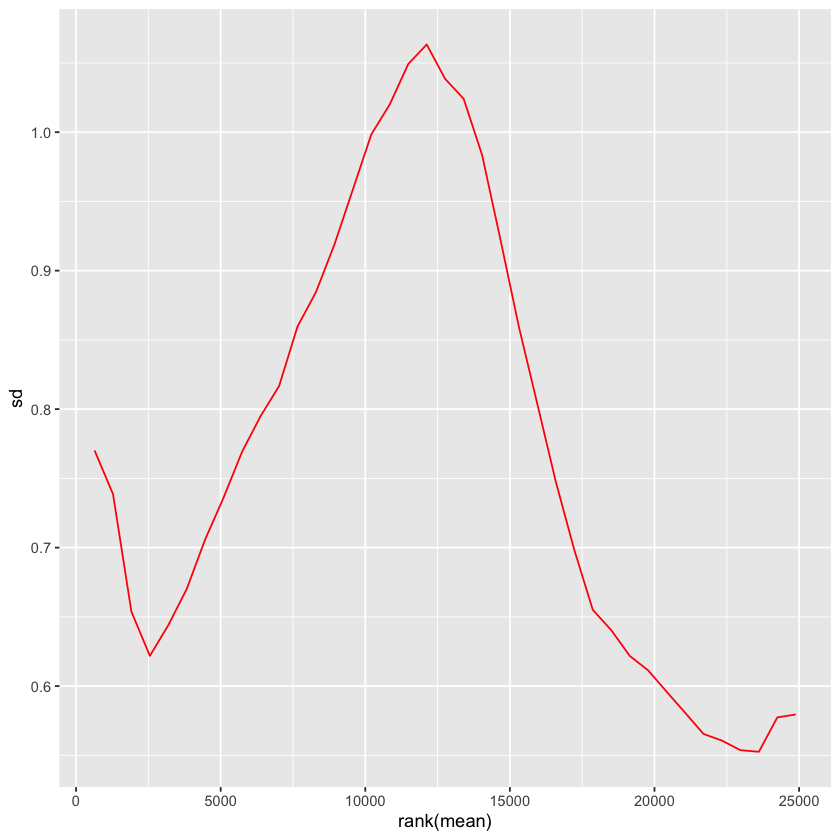

In [18]:
# 変数vsd：VST(Variance stabilizing transformations)を適用、なにこれ？
vsd <- vst(ddsSE)
meanSdPlot(assay(vsd))
head(assay(vsd))

## 5. 図をプロット

### ・MAプロット

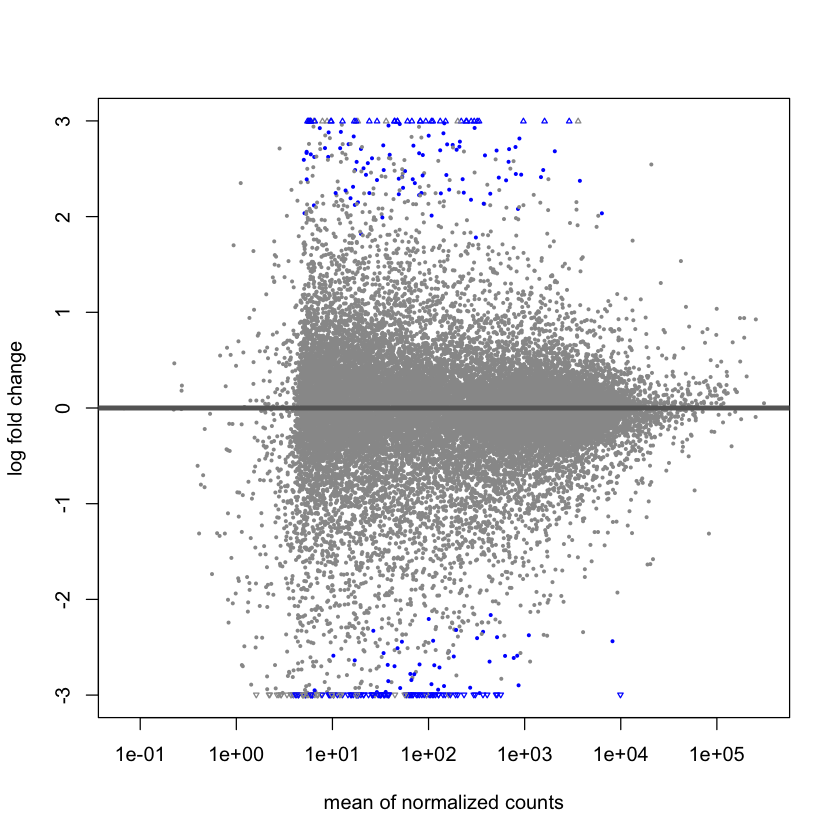

In [20]:
# MAプロット
plotMA(res, alpha = 0.1)

### ・Volcanoプロット

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


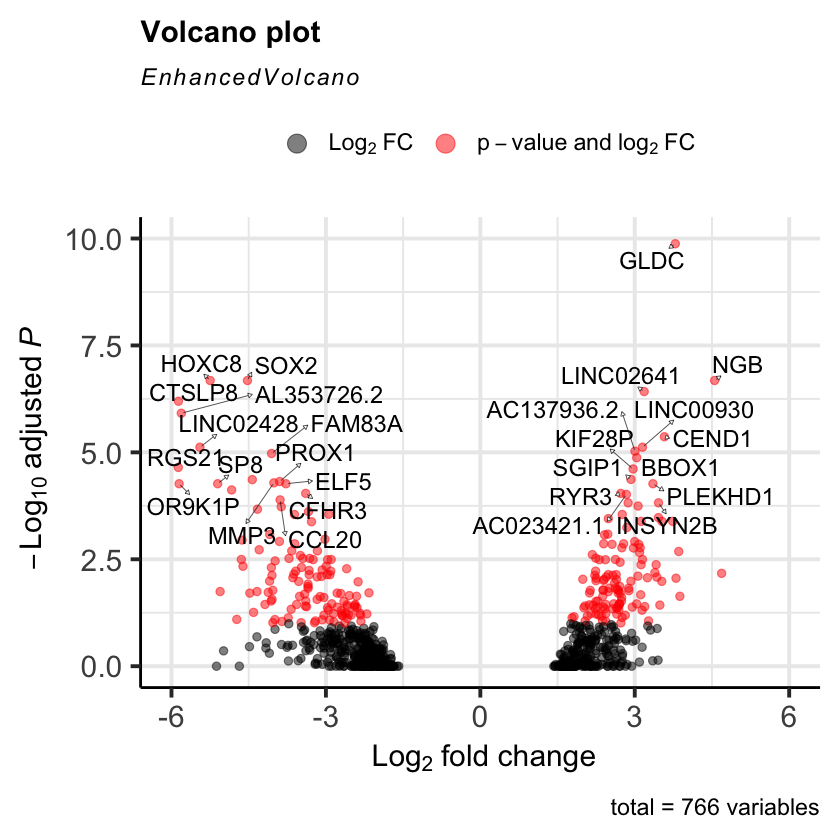

In [21]:
# P値低いやつのみ抽出
res.vol <- res[res$pvalue < 0.05,]

# グラフ出力
# pdf("output/Plot_volcano_plot.pdf", width = 15, height = 12) # PDF出力する時用
EnhancedVolcano(res.vol,
                lab = rownames(res.vol),
                x = "log2FoldChange",
                y = "padj",
                pCutoff = 0.1,
                FCcutoff = 1,
                xlab = bquote(~Log[2]~ "fold change"),
                ylab = bquote(~-Log[10]~adjusted~italic(P)),
                drawConnectors = TRUE,
                widthConnectors = 0.2,
                cutoffLineWidth = 0,
                selectLab = row.names(resOrdered[1:30,]),
                ylim = c(0,10),
                xlim = c(-6,6),
                col=c("black", "black", "black", "red"),)
# dev.off() # PDF出力する時用

### ・ヒートマップ ([設定参考](https://mecobalamin.hatenablog.com/entry/2018/09/25/133819))

In [22]:
# 色指定
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

cpal <- gg_color_hue(9)
ann_colors = list(
  primary_pathology_history_myasthenia_gravis = c(YES = "red", NO = "white"),
  primary_pathology_histological_type_list = c(A = cpal[1], "A;AB"=cpal[2], AB=cpal[3], B1=cpal[4], "B1;B2"=cpal[5], B2=cpal[6], "B2;B3"=cpal[7], B3=cpal[8], C=cpal[9])
)

# 描画
#pdf("pheatmap.pdf", width = 16, height = 16) # これ使うとバグる(正常なpdfファイルにならない) → 関数中の変数filenameで指定
pheatmap(assay(vsd)[c("NEFM", "NEFL", "GABRA5", "GABRE", "RYR3", "CHRNA1", "RBFOX1", "RBFOX3", "GLRA4", "NGB",
                      "PLXNB3", "LHFPL4"),]
         , annotation_col=df, color = viridis(10), annotation_colors = ann_colors
         , clustering_distance_rows = "correlation", clustering_method = "ward.D2"
         , treeheight_row = 100, width=30, height=10, filename = "output/Plot_pheatmap.pdf")
#dev.off() 

<img src="output/Plot_pheatmap.jpeg">

### ・PCAプロット

In [24]:
levels(vsd$primary_pathology_histological_type_list) <- c( "Thymoma; Type A", "Thymoma; Type AThymoma; Type AB", "Thymoma; Type AB", "Thymoma; Type B1", "Thymoma; Type B1Thymoma; Type B2",
                                                          "Thymoma; Type B2", "Thymoma; Type B2Thymoma; Type B3", "Thymoma; Type B3", "Thymoma; Type C" )
vsd$primary_pathology_histological_type_list <- revalue(vsd$primary_pathology_histological_type_list, c("Thymoma; Type A" = "A", "Thymoma; Type AThymoma; Type AB" = "A;AB", "Thymoma; Type AB" = "AB", "Thymoma; Type B1" = "B1", "Thymoma; Type B1Thymoma; Type B2" = "B1;B2",
                                                                                                      "Thymoma; Type B2" = "B2", "Thymoma; Type B2Thymoma; Type B3" = "B2;B3", "Thymoma; Type B3" = "B3", "Thymoma; Type C" = "C"))

pdf("output/Plot_PCA.pdf", width = 10, height = 5)
p1 <- plotPCA(vsd, intgroup=c("primary_pathology_history_myasthenia_gravis")) + 
  stat_ellipse(type = "norm", level = 0.67, geom = "polygon", alpha = 0.1, aes(fill = primary_pathology_history_myasthenia_gravis)) +
  ggtitle("Myasthenia gravis") +
  theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom")
p2 <- plotPCA(vsd, intgroup=c("primary_pathology_histological_type_list")) +  
  ggtitle("Histological type") +
  theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom")
gridExtra::grid.arrange(p1, p2, nrow = 1)
dev.off()

pdf 
  2

<img src="output/Plot_PCA.jpg">

### ・Barプロット

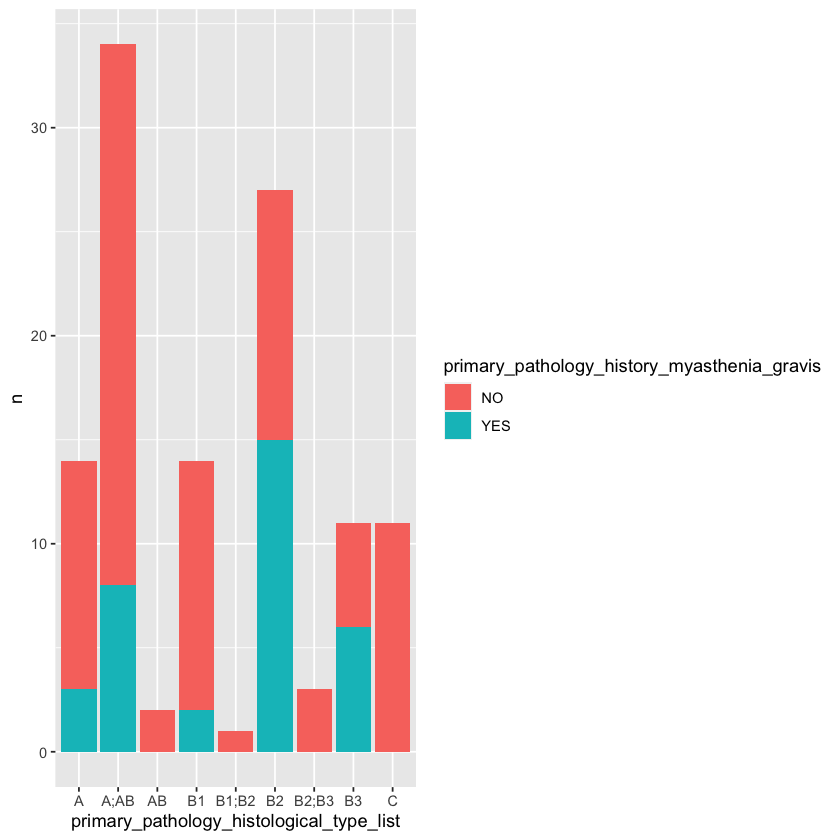

In [25]:
# stacked bar plot
mg.who <- df
mg.who <- tibble::as_tibble(mg.who)
# mg.who$primary_pathology_history_myasthenia_gravis
# mg.who <- mg.who %>% mutate(count = 1)
mg.who <- mg.who %>% 
  dplyr::group_by(primary_pathology_histological_type_list, primary_pathology_history_myasthenia_gravis) %>%
  dplyr::tally()　# %>%
  # dplyr::filter(n > 5)
  
ggplot(mg.who, aes(x = primary_pathology_histological_type_list, y = n, fill = primary_pathology_history_myasthenia_gravis)) + 
  geom_bar( stat='identity')
ggsave("output/Plot_bar.pdf", width = 7, height = 2)

### ・Violinプロット

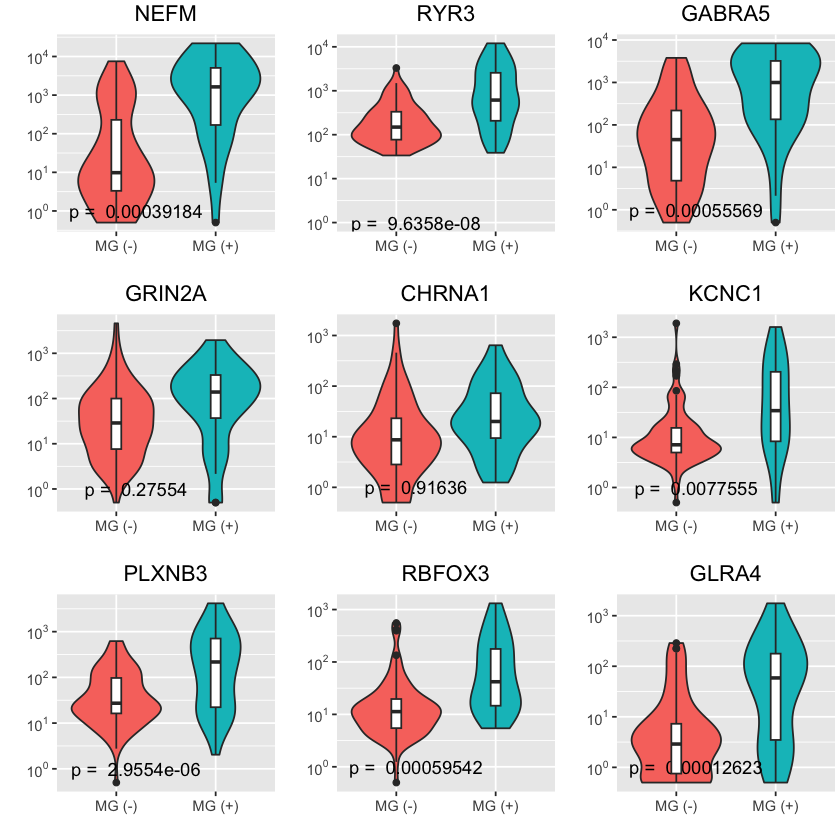

In [26]:
g <- "NEFM"

plot.violin <- function(g) {
  d <- plotCounts(ddsSE, gene=g, intgroup="primary_pathology_history_myasthenia_gravis", 
                  returnData=TRUE)
  
  levels(d$primary_pathology_history_myasthenia_gravis) <- c( "NO", "YES" )
  d$primary_pathology_history_myasthenia_gravis <- revalue(d$primary_pathology_history_myasthenia_gravis, c("NO" = "MG (-)", "YES" = "MG (+)"))
  
  pval <- res[g,"pvalue"]
  
  p <- ggplot(d, aes(x=primary_pathology_history_myasthenia_gravis, y=count)) + 
    geom_violin(adjust = 1, aes(fill = primary_pathology_history_myasthenia_gravis)) +
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                  labels = trans_format("log10", math_format(10^.x))) +
    labs("") + 
    ggtitle(g) +
    xlab("") + 
    ylab("") +
    theme(plot.title = element_text(hjust = 0.5), legend.position = 'none', plot.margin = margin(.1,.1,.1,.1, "cm")) +
    ggplot2::annotate("text", x = 1.2, y = 1, label = paste("p = ", format.pval(pval)))+
    geom_boxplot(width=0.1, fill="white")
  
  #     ylab(bquote(~Log[10]~count)) +
  return(p)
}
                  
p <- gridExtra::grid.arrange(plot.violin("NEFM"), plot.violin("RYR3"), plot.violin("GABRA5"),
                        plot.violin("GRIN2A"), plot.violin("CHRNA1"), plot.violin("KCNC1"),
                        plot.violin("PLXNB3"), plot.violin("RBFOX3"), plot.violin("GLRA4"), nrow = 3)

ggsave("output/Plot_violin.pdf", width = 7, height = 7, p)

## 6. ネットワーク解析 (WGCNA)

In [28]:
library(WGCNA)

In [ ]:
#rowSds(assay(vsd))
#plot(rowMeans((assay(vsd)), rowSds(assay(vsd))))

In [29]:
n.top <- 3000
keep <- rank(-rowSds(assay(vsd))) < n.top
oed <- vsd[keep,]

gene.names=rownames(oed)
trans.oed=t(assay(oed))
dim(trans.oed)
datExpr=trans.oed

datTraits <- data.frame(vsd$primary_pathology_history_myasthenia_gravis, vsd$primary_pathology_histological_type_list,
           vsd$gender, (vsd$age_at_diagnosis / 365))
row.names(datTraits) <- colnames(vsd)
colnames(datTraits) <- c("history_myasthenia_gravis", "histological_type",  
                         "gender", "age_at_diagnosis" )

datTraits <- binarizeCategoricalColumns(datTraits, dropFirstLevelVsAll = FALSE)
colnames(datTraits)
datTraits <- datTraits[,c("history_myasthenia_gravis.YES.vs.all", "histological_type.A.vs.all", "histological_type.A;AB.vs.all", "histological_type.B1.vs.all", "histological_type.B2.vs.all", "histological_type.B2;B3.vs.all",
            "histological_type.B3.vs.all", "histological_type.C.vs.all", "gender.male.vs.all", "age_at_diagnosis" )]

# Re-cluster samples
sampleTree2 = hclust(dist(datExpr), method = "average")

# Convert traits to a color representation: white means low, red means high, grey means missing entry
traitColors = numbers2colors(datTraits, signed = FALSE);

[1]  117 2999

[1] "history_myasthenia_gravis.NO.vs.all" 
 [2] "history_myasthenia_gravis.YES.vs.all"
 [3] "histological_type.A.vs.all"          
 [4] "histological_type.A;AB.vs.all"       
 [5] "histological_type.B1.vs.all"         
 [6] "histological_type.B2.vs.all"         
 [7] "histological_type.B2;B3.vs.all"      
 [8] "histological_type.B3.vs.all"         
 [9] "histological_type.C.vs.all"          
[10] "gender.female.vs.all"                
[11] "gender.male.vs.all"                  
[12] "age_at_diagnosis"

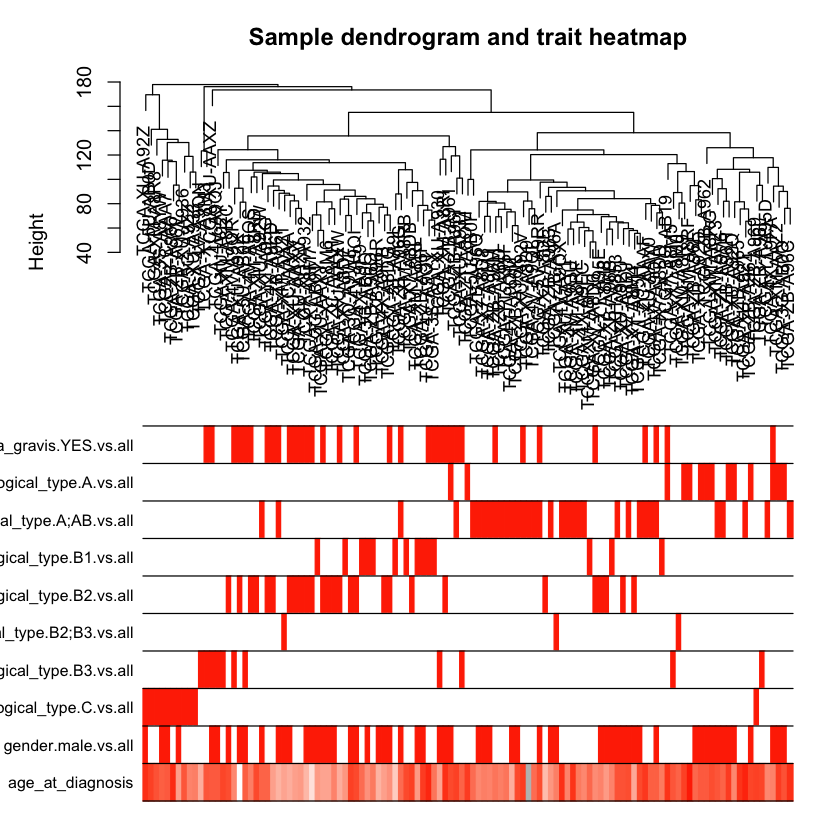

In [31]:
# Plot the sample dendrogram and the colors underneath.
#pdf("output/WGCNA_traits.pdf", width = 16, height = 8)
plotDendroAndColors(sampleTree2, traitColors,
                    groupLabels = names(datTraits),
                    main = "Sample dendrogram and trait heatmap")
#dev.off()

In [32]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))

# Call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5)

pickSoftThreshold: will use block size 2999.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2999 of 2999


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.4710  1.140          0.789  810.00   826.000 1280.0
2      2   0.0141 -0.109          0.559  332.00   318.000  698.0
3      3   0.5040 -0.402          0.756  168.00   143.000  422.0
4      4   0.8600 -0.777          0.928   97.10    69.400  315.0
5      5   0.9250 -1.000          0.958   61.70    36.900  256.0
6      6   0.9380 -1.130          0.948   42.10    21.000  215.0
7      7   0.9210 -1.190          0.919   30.30    12.400  185.0
8      8   0.9290 -1.200          0.919   22.70     7.670  162.0
9      9   0.9030 -1.210          0.886   17.60     4.750  143.0
10    10   0.9130 -1.200          0.895   14.10     3.010  127.0
11    12   0.8950 -1.180          0.872    9.49     1.350  103.0
12    14   0.8880 -1.160          0.864    6.80     0.662   84.6
13    16   0.8790 -1.140          0.853    5.09     0.344   70.6
14    18   0.8670 -1.130          0.842    3.94     0.183   59.5
15    20   0.8760 -1.100 

In [34]:
pdf("output/WGCNA_topology.pdf", width = 10, height = 5)

# sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=cex1, col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

dev.off()

pdf 
  2

In [35]:
softPower = 5;
adjacency = adjacency(datExpr, power = softPower);
# Turn adjacency into topological overlap
TOM = TOMsimilarity(adjacency);
dissTOM = 1-TOM

# Call the hierarchical clustering function
geneTree = hclust(as.dist(dissTOM), method = "average");
# Plot the resulting clustering tree (dendrogram)
sizeGrWindow(12,9)
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04);

# We like large modules, so we set the minimum module size relatively high:
minModuleSize = 50;
# Module identification using dynamic tree cut:
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,
                            deepSplit = 2, pamRespectsDendro = FALSE,
                            minClusterSize = minModuleSize);
table(dynamicMods)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
 ..cutHeight not given, setting it to 0.995  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
   0    1    2    3    4    5    6    7    8 
  32 1010  794  327  288  175  162  117   94 

In [36]:
# Convert numeric lables into colors
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)
# Plot the dendrogram and colors underneath
sizeGrWindow(8,6)
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")

dynamicColors
    black      blue     brown     green      grey      pink       red turquoise 
      117       794       327       175        32        94       162      1010 
   yellow 
      288 

In [37]:
# Calculate eigengenes
MEList = moduleEigengenes(datExpr, colors = dynamicColors)
MEs = MEList$eigengenes
# Calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs);
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average");
# Plot the result
sizeGrWindow(7, 6)
plot(METree, main = "Clustering of module eigengenes",
     xlab = "", sub = "")

MEDissThres = 0.2
# Plot the cut line into the dendrogram
abline(h=MEDissThres, col = "red")
# Call an automatic merging function
merge = mergeCloseModules(datExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# The merged module colors
mergedColors = merge$colors;
# Eigengenes of the new merged modules:
mergedMEs = merge$newMEs;
table(mergedColors)

 mergeCloseModules: Merging modules whose distance is less than 0.2
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 9 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 8 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 8 module eigengenes in given set.


mergedColors
    black      blue     green      grey      pink       red turquoise    yellow 
      117      1121       175        32        94       162      1010       288 

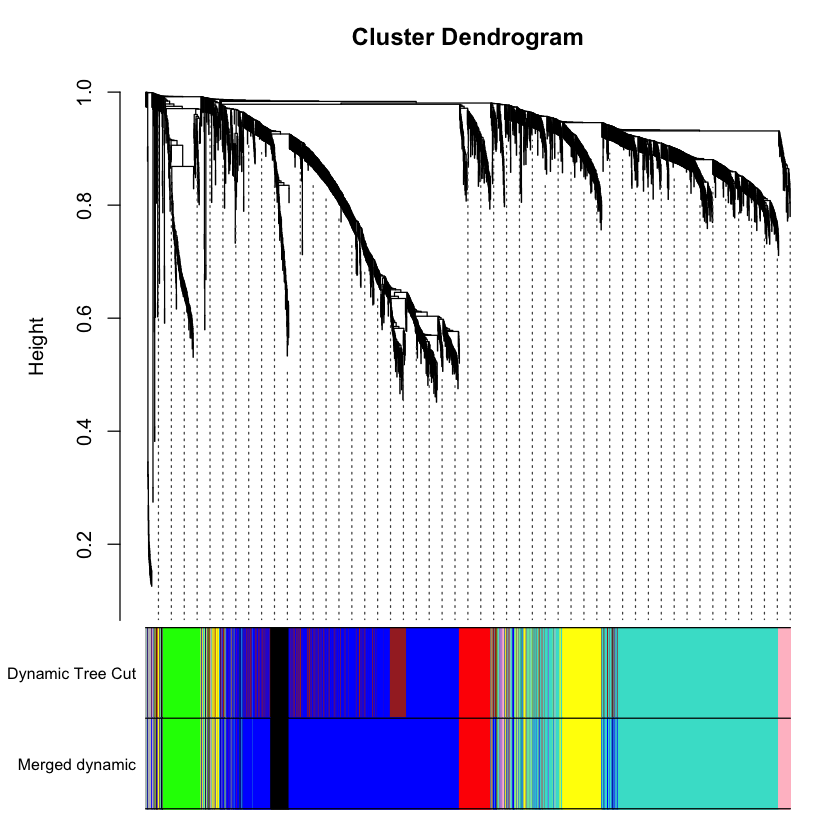

In [40]:
#pdf("output/WGCNA_dendromerge.pdf", width = 10, height = 5)
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)
#dev.off()

In [41]:
# Rename to moduleColors
moduleColors = mergedColors
# Construct numerical labels corresponding to the colors
colorOrder = c("grey", standardColors(50));
moduleLabels = match(moduleColors, colorOrder)-1;
MEs = mergedMEs;
# Save module colors and labels for use in subsequent parts
# save(MEs, moduleLabels, moduleColors, geneTree, file = "200703_DSeq2WGCNA/02-networkConstruction-stepByStep.RData")


# Define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);
# Recalculate MEs with color labels
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, datTraits, use = "p")
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples)

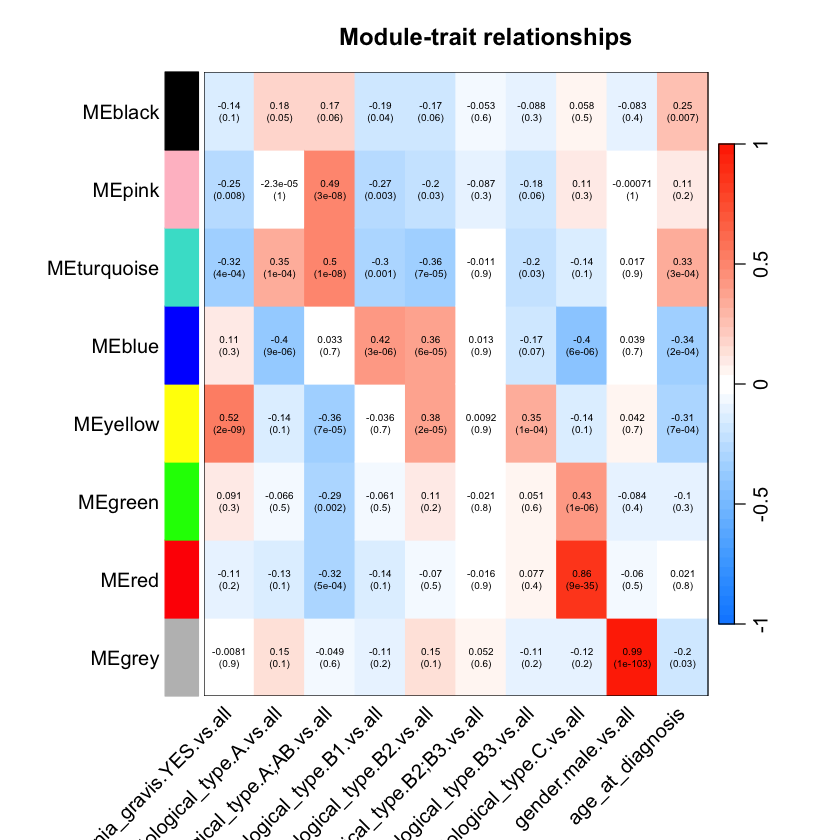

In [43]:
#pdf("output/WGCNA_heattrait.pdf", width = 8, height = 5)

# Will display correlations and their p-values
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                   signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));
# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))
#dev.off()

## 7. Pathway解析 (Reactome)

In [45]:
library(magrittr)
library(clusterProfiler)
library(ReactomePA)
library(org.Hs.eg.db)

In [ ]:
mg = as.data.frame(datTraits$history_myasthenia_gravis.YES.vs.all)
names(mg) = "myasthenia_gravis"
module.mg = "yellow"

mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))

genes <- gene.names[moduleColors==module.mg][res[gene.names[moduleColors==module.mg],'log2FoldChange'] > 1]
r <- res[genes,]
q <- getBM(filters="hgnc_symbol", attributes=c("entrezgene_id", "hgnc_symbol"), values=row.names(r), mart=mart, )
genes.entrez <- q$entrezgene_id
r <- r[q$hgnc_symbol,]
r <- r[!is.na(q$entrezgene_id),]
row.names(r) <- q[!is.na(q$entrezgene_id),'entrezgene_id']
rlfc <- r$log2FoldChange
names(rlfc) <- q[!is.na(q$entrezgene_id),'entrezgene_id']

In [ ]:
x <- enrichPathway(gene=genes.entrez ,pvalueCutoff=0.2, readable=T)

In [ ]:
head(as.data.frame(x))

barplot(x, showCategory=6)

pdf("output/Reactome_dot.pdf", width = 10, height = 4)
dotplot(x, showCategory=6)
dev.off()

In [ ]:
pdf("output/Reactome_cnet.pdf", width = 8, height = 5)
cnetplot(x, showCategory = 6, categorySize="pvalue", foldChange=rlfc,)
dev.off()

In [ ]:
genes <- gene.names[moduleColors==module.mg][res[gene.names[moduleColors==module.mg],'log2FoldChange'] < -1]
r <- res[genes,]
q <- getBM(filters="hgnc_symbol", attributes=c("entrezgene_id", "hgnc_symbol"), values=row.names(r), mart=mart, )
genes.entrez <- q$entrezgene_id
r <- r[q$hgnc_symbol,]
r <- r[!is.na(q$entrezgene_id),]
row.names(r) <- q[!is.na(q$entrezgene_id),'entrezgene_id']
rlfc <- r$log2FoldChange
names(rlfc) <- q[!is.na(q$entrezgene_id),'entrezgene_id']

x <- enrichPathway(gene=genes.entrez ,pvalueCutoff=0.2, readable=T)
head(as.data.frame(x))

barplot(x, showCategory=6)

pdf("output/Reactome_yellow_dot.pdf", width = 10, height = 4)
dotplot(x, showCategory=6)
dev.off()

In [ ]:
ego <- enrichGO(gene          = genes.entrez,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
                readable      = TRUE)

dotplot(ego)